In [1]:
#Required libraries.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import math
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
import string
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from collections import Counter
from operator import itemgetter
from pprint import pprint
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))

[nltk_data] Downloading package punkt to /home/furkan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/furkan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def read_corpus():
    '''Reads corpus from files.'''
    
    documents = []
    orig_docs = []
    DIR = './'
    tknzr = TweetTokenizer()
    with open("../../Exercises/01.Vector_Space_Retrieval/epfldocs.txt", encoding = "utf-8") as f:
        content = f.readlines()
    for text in content:
        orig_docs.append(text)
        # split into words
        tokens = tknzr.tokenize(text)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        words = [w for w in words if not w in stop_words]

        documents.append(' '.join(words))
    return documents, orig_docs

In [5]:
documents, orig_docs = read_corpus()

In [6]:
len(documents)

1075

# Question 1: Latent semantic indexing

## Question 1.1: Build the vocabulary by selecting top-k frequent words

In [7]:
def create_vocabulary_frequency(corpus, vocab_len):
    '''Select top-k (k = vocab_len) words in term of frequencies as vocabulary'''
    
    count = {}
    for document in corpus:
        for word in document.split():
            if word in count:
                count[word] += 1
            else:
                count[word] = 1
    
    sorted_count_by_freq = sorted(count.items(), key=lambda kv: kv[1], reverse=True)

    vocabulary = [x[0] for x in sorted_count_by_freq[:vocab_len]]
    return vocabulary


In [8]:
vocab_freq = create_vocabulary_frequency(documents, 1000)

In [9]:
vocab_freq

['epfl',
 'epflen',
 'via',
 'new',
 'lausanne',
 'switzerland',
 'vdtech',
 'research',
 'swiss',
 'science',
 'students',
 'innovation',
 'first',
 'martinvetterli',
 'day',
 'solar',
 'great',
 'open',
 'unil',
 'data',
 'technology',
 'learning',
 'thanks',
 'ethen',
 'work',
 'prof',
 'today',
 'startup',
 'talk',
 'see',
 'days',
 'next',
 'congrats',
 'one',
 'good',
 'suisse',
 'researchers',
 'campus',
 'center',
 'time',
 'eth',
 'energy',
 'robots',
 'join',
 'us',
 'epflcampus',
 'cc',
 'made',
 'lab',
 'dgtswitzerland',
 'world',
 'brain',
 'robot',
 'looking',
 'meeting',
 'people',
 'drone',
 'get',
 'future',
 'human',
 'mooc',
 'perovskite',
 'could',
 'epflenac',
 'free',
 'robotics',
 'event',
 'marcelsalathe',
 'conference',
 'proud',
 'light',
 'workshop',
 'forward',
 'week',
 'school',
 'der',
 'president',
 'universities',
 'design',
 'read',
 'im',
 'university',
 'scientists',
 'watch',
 'cours',
 'team',
 'article',
 'last',
 'top',
 'take',
 'exciting',
 'ma

## Question 1.2: Construct the term document matrix
Construct the term document matrix given the vocabulary and the set of documents

In [10]:
def construct_term_document_matrix(vocabulary, documents):
    # Construct term-doc matrix
    matrix = np.zeros((len(vocabulary), len(documents)))
    for j, document in enumerate(documents):
        counter = Counter(document.split())
        for i, word in enumerate(vocabulary):
            if word in counter:
                matrix[i,j] = counter[word]
    return matrix

In [11]:
term_doc_matrix_freq = construct_term_document_matrix(vocab_freq, documents)

## Question 1.3: Perform latent semantic indexing by selecting the first 100 largest singular values of the term document matrix  
Hint 1: np.linalg.svd(M, full_matrices=False) performs SVD on the matrix $\mathbf{M}$ and returns $\mathbf{K}, \mathbf{S}, \mathbf{D}^T$

 -  $\mathbf{K}, \mathbf{D}^T$ are matrices with orthonormal columns
 -  $\mathbf{S}$ is a **vector** of singular values in a **descending** order
 
Hint 2: np.diag(V) converts a vector to a diagonal matrix

Hint 3: To select 
 - The first k rows of a matrix A, use A[0:k, :]
 - The first k columns of a matrix A, use A[:, 0:k]
 - The submatrix from first k rows and k columns: use A[0:k, 0:k]

In [12]:
def truncated_svd(term_doc_matrix, num_val):
    K, S, Dt = np.linalg.svd(term_doc_matrix, full_matrices=False)
    K_sel = K[:,0:num_val]
    S_sel = np.diag(S)[0:num_val,0:num_val]
    Dt_sel = Dt[0:num_val,:]
    return K_sel, S_sel, Dt_sel

In [13]:
K_freq, S_freq, Dt_freq = truncated_svd(term_doc_matrix_freq,100)

## Question 1.4: Transform the query 

Construct a vector representation for the following query

In [14]:
query = ['epfl']

In [15]:
def query_to_document_vector(query, vocabulary):
    vector = np.zeros(len(vocabulary))
    for word in query:
        try:
            vector[vocabulary.index(word)] += 1
        except: # if query word is not in vocabulary
            # ignore it
            pass
    return vector

Hint: 
 -  To compute inverse of a matrix M, use np.linalg.inv(M)
 -  To compute the matrix multiplication of A, B, use np.dot(A,B)

In [18]:
def construct_query_vector(query, vocabulary, K_sel, S_sel):
    q = query_to_document_vector(query, vocabulary)
    mapper = np.dot(K_sel, np.linalg.inv(S_sel))
    q_trans =  np.dot(q, mapper)
    return q_trans

In [19]:
query_vector_freq = construct_query_vector(query, vocab_freq, K_freq, S_freq)

## Question 1.5: Retrieve top-10 relevant documents

In [34]:
def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy*1.0/math.sqrt(sumxx*sumyy)

In [35]:
def retrieve_documents(query_vector, top_k, Dt_sel):
    scores = [[cosine_similarity(query_vector, Dt_sel[:,d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    retrieved = []
    for i in range(top_k):
        doc_ids.append(scores[i][1])
        retrieved.append(orig_docs[scores[i][1]])
    return doc_ids, retrieved
        

In [36]:
retrieved_ids_freq, retrieved_docs_freq = retrieve_documents(query_vector_freq, 10, Dt_freq)

/home/furkan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [37]:
pprint(retrieved_docs_freq)

['Chocolate &amp; berries #vegan cheesecake for my @EPFL coworkers! ✌🏽🌱 '
 '#veganfood #EPFLfood https://t.co/wPlLsIt0KD\n',
 "L'app pour «liker» en direct les transports publics https://t.co/3HbkTnIE3Q "
 '#epfl\n',
 'signé @EPFL https://t.co/sRldB2O7PM\n',
 "L'électrochimie débusque les protéines résistantes aux antibiotiques "
 'https://t.co/BHlj5WHMbC Avec Hubert Girault @EPFL\n',
 '#ff @Kikohs and his beautiful artworks. Some of them are displayed at @EPFL '
 'and featured on ZettaBytes! https://t.co/8F4BNL7aAs\n',
 'Ca court, ca court à #carandache #epfl #wwim15 #wwim15_igerslausanne '
 'https://t.co/0bNMBPx50k\n',
 'Femmes en politique, pour en finir avec les seconds rôles '
 'https://t.co/IgIkg8yrxy #epfl\n',
 'Le camion Cargo Congo du @theatredevidy est sur la #PlaceCosandey- ne '
 'manquez pas de venir découvrir ce spectacle de 10 mins jusqu’à 14h puis à '
 '16h @EPFL https://t.co/D2JZztA3Ca\n',
 "Bras de fer autour de la taxe d’études de l'#EPFL https://t.co/pr7GBU3f04\n",
 

# Question 2: Evaluation

In [38]:
# Retrieval oracle 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), vocabulary=vocab_freq, min_df = 1, stop_words = 'english')
features = tf.fit_transform(documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.3):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

In [39]:
gt_ids = search_vec_sklearn(" ".join(query), features)

In [40]:
for i in gt_ids:
    print(orig_docs[i].strip())

@EPFL Retrouvez votre 1er tweet sélectionné par L'important https://t.co/B2tCt924Cp
Environnement, un marché en pleine croissance https://t.co/ThTcYLrMtn Avec Philippe Thalmann @EPFL
Belle leçon de technologie dans @RTScqfd avec l'exosquelette @twiice_official testé par Silke Pan. https://t.co/4uIdXckvaq #RTScqfd #EPFL
Chocolate &amp; berries #vegan cheesecake for my @EPFL coworkers! ✌🏽🌱 #veganfood #EPFLfood https://t.co/wPlLsIt0KD
L'app pour «liker» en direct les transports publics https://t.co/3HbkTnIE3Q #epfl
I see you @EPFL ! https://t.co/BxrHPaMqlX
#Walking on two #legs isn’t as easy as it seems... @EPFL  https://t.co/Af6Shy2CvV https://t.co/ecz2M8Znl4
signé @EPFL https://t.co/sRldB2O7PM
L'électrochimie débusque les protéines résistantes aux antibiotiques https://t.co/BHlj5WHMbC Avec Hubert Girault @EPFL
#ff @Kikohs and his beautiful artworks. Some of them are displayed at @EPFL and featured on ZettaBytes! https://t.co/8F4BNL7aAs
Ca court, ca court à #carandache #epfl #wwim15 #wwi

## Question 2.1: Compute F1-score at 10 between oracle and the above result

In [41]:
def compute_recall_at_k(predict, gt, k): # gt: relevant documents
    correct_recall = set(predict[:k]).intersection(set(gt))
    return len(correct_recall)/len(gt)

In [42]:
def compute_precision_at_k(predict, gt, k):
    correct_predict = set(predict[:k]).intersection(set(gt))
    return len(correct_predict)/k

In [43]:
def f1score(predict, gt, k):
    prec = compute_precision_at_k(predict, gt, k)
    rec = compute_recall_at_k(predict, gt, k)
    print(prec, rec)
    return 2*prec*rec/(prec+rec)

In [44]:
f1score(retrieved_ids_freq, gt_ids, 10)

0.8 0.22857142857142856


0.3555555555555555

# Question 3: Plot the terms using two principal concepts

## Question 3.1: Compute term vectors using two principal concepts

In [45]:
term_vecs_freq, _, _ = truncated_svd(term_doc_matrix_freq,2)

In [46]:
term_vecs_freq.shape

(1000, 2)

### Plot the term vectors using two principal concepts

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
#from pylab import *

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Hint: You can use plt.scatter(x, y) for a scatter plot. x is a vector of x-axis value and y is a vector of y-axis value

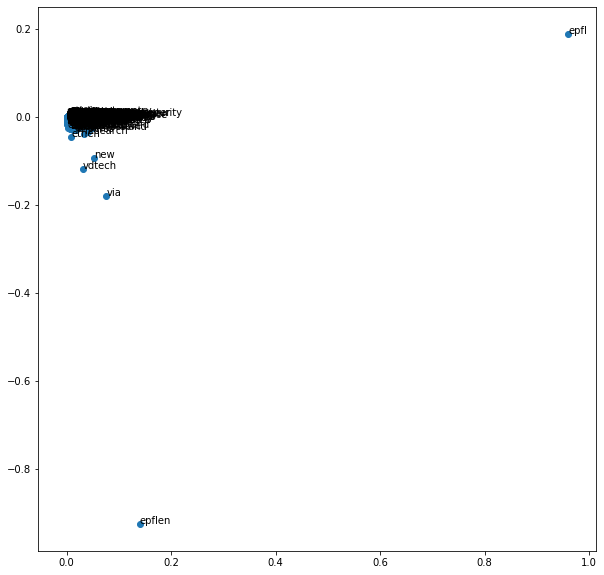

In [52]:
plt.figure(num=None, figsize=(10, 10))
plt.scatter(term_vecs_freq[:, 0], term_vecs_freq[:, 1])
for i, t in enumerate(vocab_freq):
    plt.annotate(t, (term_vecs_freq[i, 0], term_vecs_freq[i, 1]))
plt.show()

## Question 3.2: Explain the scatter plot

epfl and epflen are two Twitter handles of EPFL which explains why the two principal concepts are mainly made up of these terms.